# Laboratorium 4

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines":[linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


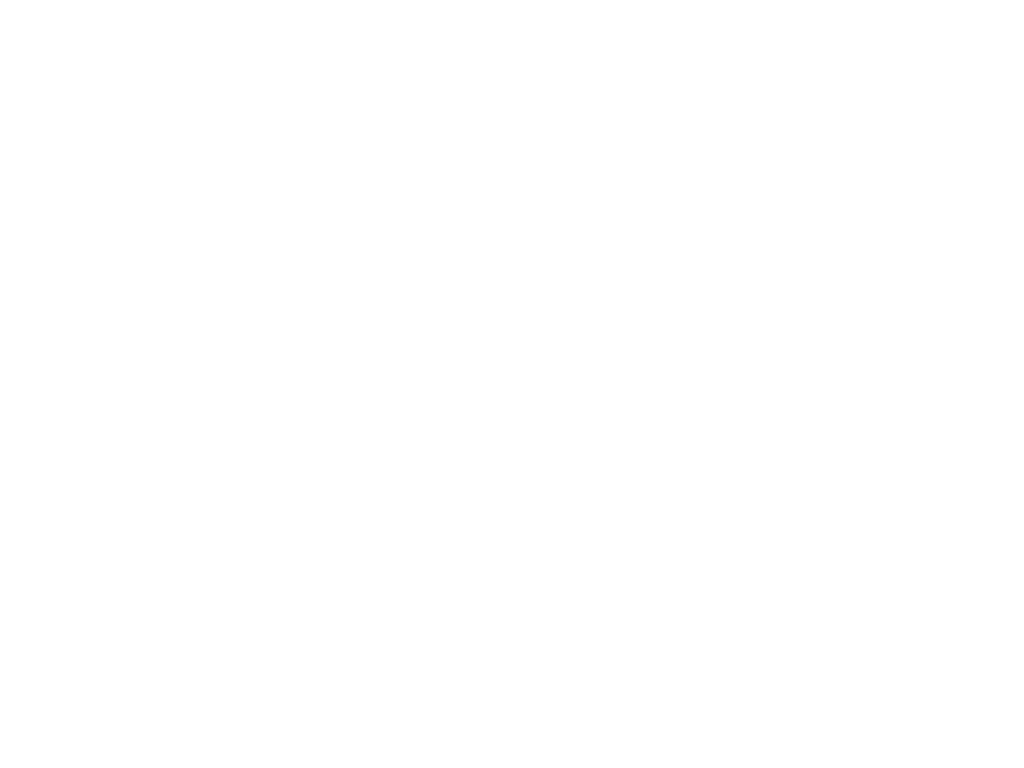

In [3]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


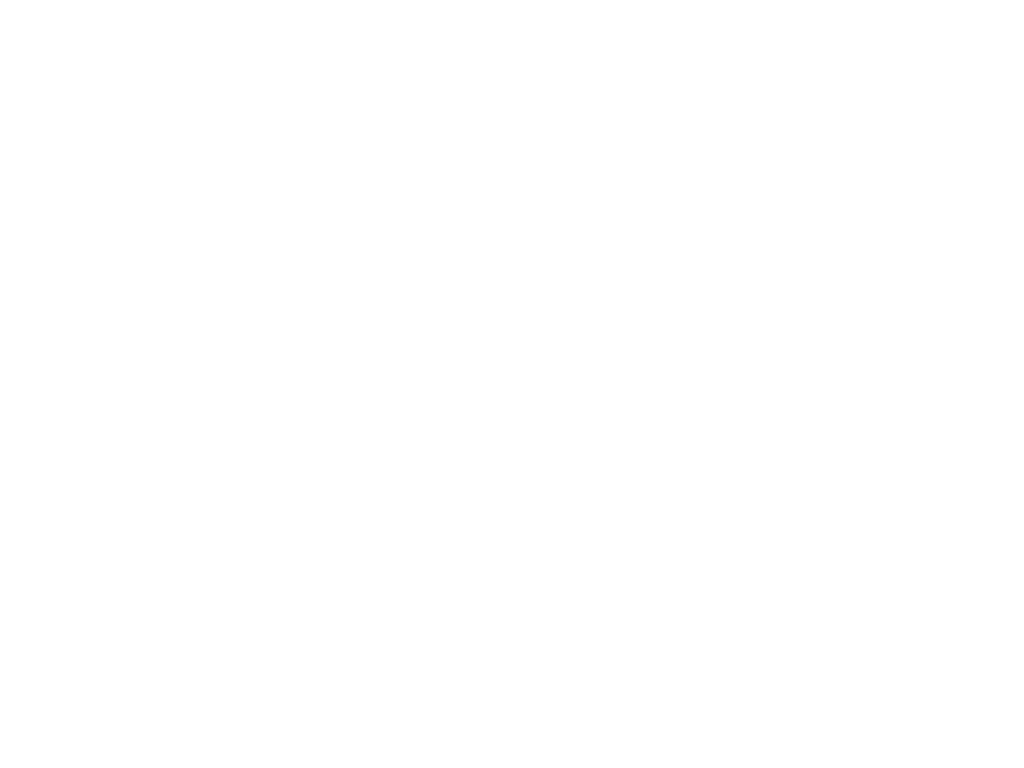

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]),
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'),
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')],
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw()

###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


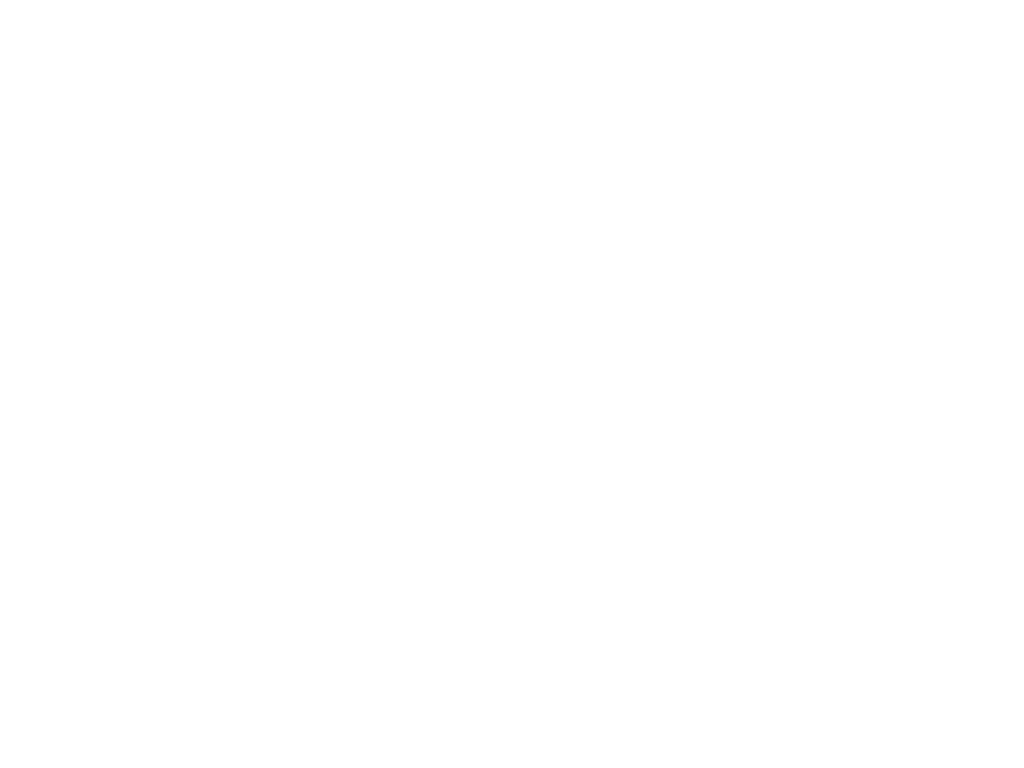

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


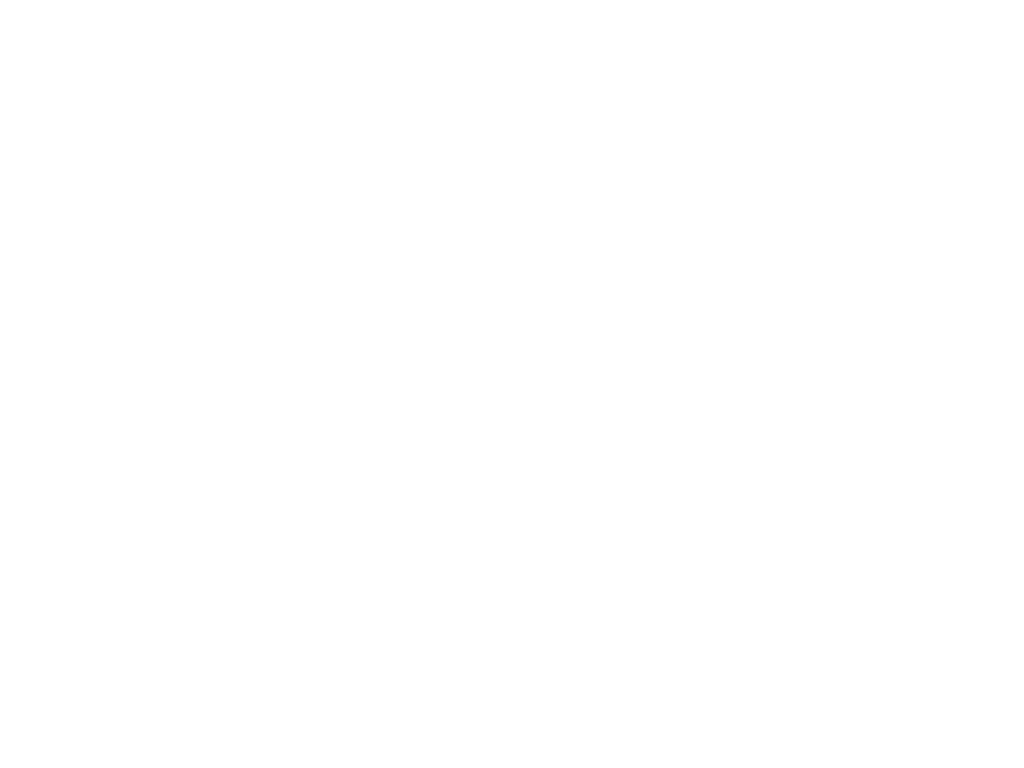

In [6]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


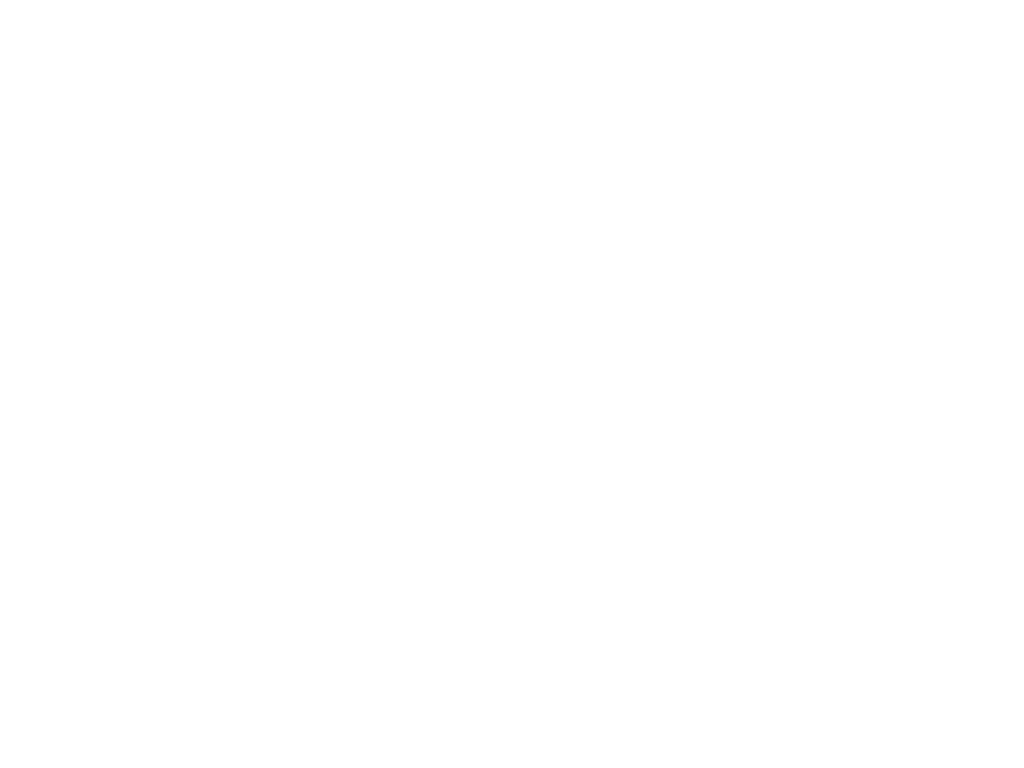

In [7]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

# ROZWIĄZANIE

# Przygotowanie narzędzi

### epsilon

In [8]:
EPSILON = 10 ** -12

### przygotowanie bibliotek

In [9]:
from random import uniform
from math import sqrt
from heapq import heapify, heappop
from functools import reduce
from sortedcontainers import SortedSet

### obliczanie wyznacznika

In [10]:
def det(a, b, c):
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c

    return ((a_x - c_x) * (b_y - c_y)) - ((a_y - c_y) * (b_x - c_x))

### określanie orientacji

In [11]:
def orient(a, b, c, epsilon=EPSILON):
    determinant = det(a, b, c)

    if determinant < -epsilon:
        return -1
    elif determinant > epsilon:
        return 1
    else:
        return 0

### struktura punktu

In [12]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __le__(self, other):
        return self.x <= other.x

    def __lt__(self, other):
        return self.x < other.x

    def __hash__(self):
        return self.x.__hash__() * self.y.__hash__()

    def __str__(self):
        return "Point(%s,%s)" % (self.x, self.y)

    def move(self, dx, dy):
        self.x += dx
        self.y += dy

    def lines(self, line_1, line_2):
        self.line_1 = line_1
        self.line_2 = line_2

    def get_x(self):
        return self.x

    def get_y(self):
        return self.y

    def to_tuple(self):
        return self.x, self.y

### struktura linii

In [13]:
class Line:
    def __init__(self, point_1, point_2):
        if point_1.x < point_2.x:
            self.point_1 = point_1
            self.point_2 = point_2
        else:
            self.point_1 = point_2
            self.point_2 = point_1

    def __str__(self):
        x1,y1 = self.point_1.x, self.point_1.y
        x2,y2 = self.point_2.x, self.point_2.y

        return "((%f,%f),(%f,%f))" % (x1,y1,x2,y2)

    def get_equation(self, x):
        a = (self.point_2.y - self.point_1.y) / (self.point_2.x - self.point_1.x)
        b = self.point_2.y - a * self.point_2.x

        return a * x + b

    def get_length(self):
        dist_x = abs(self.point_1.x - self.point_2.x)
        dist_y = abs(self.point_2.y - self.point_2.y)

        return sqrt(dist_x ** 2 + dist_y ** 2)

    def to_tuple(self):
        return self.point_1.to_tuple(), self.point_2.to_tuple()

### zapisywanie do pliku

In [14]:
def save_to_file(file_name, lines):
    with open(f"{file_name}.json", "w") as file:
        file.write(f"lines: {lines}")

### wczytywanie z pliku

In [15]:
def load_from_file(file_name):
    with open(f"{file_name}.json", "r") as file:
        lines = file.readlines()

    return lines

### przygotowanie odcinków z wykresu jako lista krotek

In [16]:
def get_lines_from_plot_as_tuples(plot):
    lines_in_plot = plot.get_added_lines()
    lines_as_tuples = []

    for line in lines_in_plot:
        l = line.lines
        lines_as_tuples.append((l[0], l[1]))

    return lines_as_tuples

### generowanie zbioru losowych linii

In [17]:
def generate_random_lines(n=10, lower_left=(-10,-10), upper_right=(10,10)):
    lines = []
    points_xs = set()
    ll_x = lower_left[0]
    ll_y = lower_left[1]
    ur_x = upper_right[0]
    ur_y = upper_right[1]

    for i in range(n):
        point_1 = (uniform(ll_x, ur_x), uniform(ll_y, ur_y))
        point_2 = (uniform(ll_x,ur_x), uniform(ll_y, ur_y))

        while point_1[0] == point_2[0] or point_1[0] in points_xs or point_2[0] in points_xs:
            point_1 = (uniform(ll_x, ur_x), uniform(ll_y, ur_y))
            point_2 = (uniform(ll_x,ur_x), uniform(ll_y, ur_y))

        if point_1[0] < point_2[0]:
            lines.append((point_1, point_2))
        else:
            lines.append((point_2, point_1))

        points_xs.add(point_1[0])
        points_xs.add(point_2[0])

    return lines

### sprawdzanie przecięcia

In [18]:
def check_intersection(line_1, line_2):
    return (orient(line_1[0], line_1[1], line_2[0]) != orient(line_1[0], line_1[1], line_2[1])) and (orient(line_2[0], line_2[1], line_1[0]) != orient(line_2[0], line_2[1], line_1[1]))

### obliczenie punktu przecięcia

In [19]:
def find_intersection(line_1, line_2):
        check_1_with_2_x = orient(line_1.point_1.to_tuple(), line_1.point_2.to_tuple(), line_2.point_1.to_tuple())
        check_1_with_2_y = orient(line_1.point_1.to_tuple(), line_1.point_2.to_tuple(), line_2.point_2.to_tuple())
        check_1_with_2 = check_1_with_2_x != check_1_with_2_y

        check_2_with_1_x = orient(line_2.point_1.to_tuple(), line_2.point_2.to_tuple(), line_1.point_1.to_tuple())
        check_2_with_1_y = orient(line_2.point_1.to_tuple(), line_2.point_2.to_tuple(), line_1.point_2.to_tuple())
        check_2_with_1 = check_2_with_1_x != check_2_with_1_y

        if check_1_with_2 and check_2_with_1:
            x_start_1 = line_1.point_1.x
            y_start_1 = line_1.point_1.y
            x_start_2 = line_2.point_1.x
            y_start_2 = line_2.point_1.y
            delta_x_1 = line_1.point_2.x - line_1.point_1.x
            delta_x_2 = line_2.point_2.x - line_2.point_1.x
            delta_y_1 = line_1.point_2.y - line_1.point_1.y
            delta_y_2 = line_2.point_2.y - line_2.point_1.y

            a_1 = delta_y_1 / delta_x_1
            b_1 = y_start_1 - (a_1 * x_start_1)

            a_2 = delta_y_2 / delta_x_2
            b_2 = y_start_2 - (a_2 * x_start_2)

            x = (b_2 - b_1) / (a_1 - a_2)
            y = (a_1 * (b_2 - b_1) / (a_1 - a_2)) + b_1

            point_of_intersection = Point(x, y)
            point_of_intersection.lines(line_1, line_2)
            return point_of_intersection

        return None

### konwersja odcinków

In [20]:
def convert_lines(lines):
    for index, line in enumerate(lines):
        point_1 = Point(line[0][0], line[0][1])
        point_2 = Point(line[1][0], line[1][1])

        lines[index] = Line(point_1, point_2)

    return lines

# Sprawdzanie, czy choć jedna para odcinków się przecina

In [21]:
class Broom_1:
    def __init__(self, lines, lower_left, upper_right):
        self.lines = lines
        self.lower_left = lower_left
        self.upper_right = upper_right
        self.scenes = []
        self.events = []
        self.sorted_lines = SortedSet(key=lambda x: x[0][1])

        for line in lines:
            self.events.append((line[0][0], line))
            self.events.append((line[1][0], line))

        heapify(self.events)

    def sweep(self):
        while self.events:
            current_event = heappop(self.events)

            if self.state(current_event):
                return False

        return True

    def add_line(self, line):
        self.sorted_lines.add(line)
        index = self.sorted_lines.index(line)

        if index >= 1 or index < len(self.sorted_lines) - 1:
            return check_intersection(self.sorted_lines[index - 1], line)

    def remove_line(self, line):
        index = self.sorted_lines.index(line)

        if 1 <= index < len(self.sorted_lines) - 1:
            return check_intersection(self.sorted_lines[index - 1], self.sorted_lines[index + 1])
        else:
            self.sorted_lines.remove(line)

    def state(self, event):
        if event[0] == event[1][0][0]:
            self.scenes.append(Scene(
                [PointsCollection([event[1][0]], color='orange')],
                [LinesCollection(list(self.lines)),
                 LinesCollection([((event[0], self.lower_left[1]), (event[0], self.upper_right[1]))], color='red')]))
            return self.add_line(event[1])
        else:
            self.scenes.append(Scene(
                [PointsCollection([event[1][1]], color='orange')],
                [LinesCollection(self.lines),
                 LinesCollection([((event[0], self.lower_left[1]), (event[0], self.upper_right[1]))], color='red')]))
            return self.remove_line(event[1])

# Wyznaczanie wszystkich przecięć

In [22]:
class Broom_2:
    def __init__(self):
        self.scenes = []
        self.lines = dict()
        self.sorted_lines = SortedSet()
        self.events = SortedSet(key=lambda point: -point.x)
        self.intersection = set()

    def sweep(self, lines):
        for line in lines:
            self.lines[line.point_1] = line
            self.lines[line.point_2] = line
            self.events.add(line.point_1)
            self.events.add(line.point_2)

        min_y = reduce(lambda curr, point: point if point.y < curr.y else curr, self.lines.keys()).y
        max_y = reduce(lambda curr, point: point if point.y > curr.y else curr, self.lines.keys()).y

        curr_lines = SortedSet(key=lambda line: line.get_equation(self.events[0].x))
        curr_lines.update(self.sorted_lines)
        self.sorted_lines = curr_lines

        while self.events:
            event = self.events.pop()
            self.scenes.append(Scene([PointsCollection([event.to_tuple()], color="orange"),
                                      PointsCollection(list(map(lambda point: point.to_tuple(), self.intersection)), color="red")],
                                     [LinesCollection(list(map(lambda line: line.to_tuple(), lines))),
                                      LinesCollection([((event.x, min_y), (event.x, max_y))], color="red")]))
            self.state(event)

        return self.intersection

    def add_line(self, line):
        self.sorted_lines.add(line)
        index = self.sorted_lines.index(line)

        if 1 <= index < len(self.sorted_lines)-1:
            intersection = find_intersection(self.sorted_lines[index - 1], self.sorted_lines[index + 1])
            if intersection is not None and intersection in self.events:
                self.events.remove(intersection)
        if index >= 1:
            intersection = find_intersection(self.sorted_lines[index - 1], line)
            if intersection is not None and intersection not in self.events and intersection not in self.intersection:
                self.events.add(intersection)
        if index < len(self.sorted_lines)-1:
            intersection = find_intersection(line, self.sorted_lines[index + 1])
            if intersection is not None and intersection not in self.events and intersection not in self.intersection:
                self.events.add(intersection)

    def remove_line(self, line):
        index = self.sorted_lines.index(line)

        if 1 <= index < len(self.sorted_lines) - 1:
            intersection = find_intersection(self.sorted_lines[index - 1], self.sorted_lines[index + 1])
            if intersection is not None and intersection not in self.intersection:
                self.events.add(intersection)

        self.sorted_lines.remove(line)

    def state(self, event):
        if event in self.lines:
            line = self.lines[event]
            curr_lines = SortedSet(key=lambda line: line.get_equation(event.x))
            curr_lines.update(self.sorted_lines)
            self.sorted_lines = curr_lines

            if event == line.point_1:
                self.add_line(line)
            else:
                self.remove_line(line)
        else:
            self.intersection.add(event)

            line_1 = event.line_1
            self.remove_line(line_1)
            line_2 = event.line_2
            self.remove_line(line_2)

            curr_lines = SortedSet(key=lambda line: line.get_equation(event.x + EPSILON))
            curr_lines.update(self.sorted_lines)
            self.sorted_lines = curr_lines
            self.add_line(line_1)
            self.add_line(line_2)

# Losowy zbiór testowy

<IPython.core.display.Javascript object>


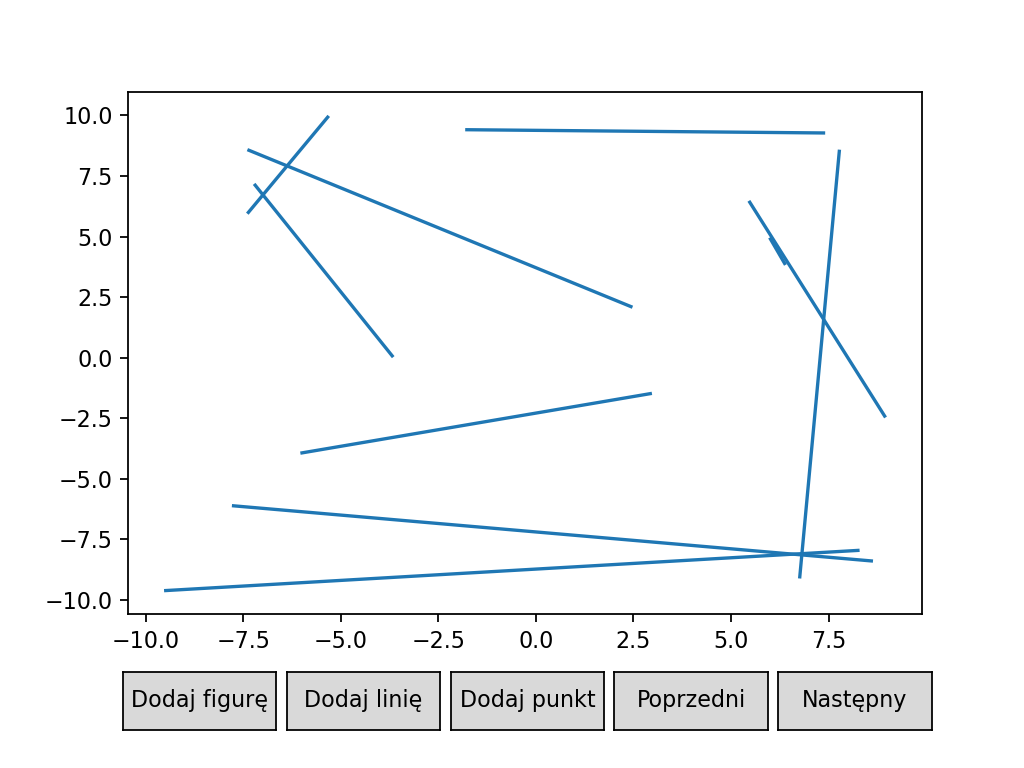

In [30]:
n = 10
left_lower_corner = (-10,-10)
right_upper_corner = (10,10)

random_lines = generate_random_lines(n, left_lower_corner, right_upper_corner)
plot = Plot([Scene(lines=[LinesCollection(random_lines)])])
plot.draw()

# Zbiór testowy nr 1

<IPython.core.display.Javascript object>


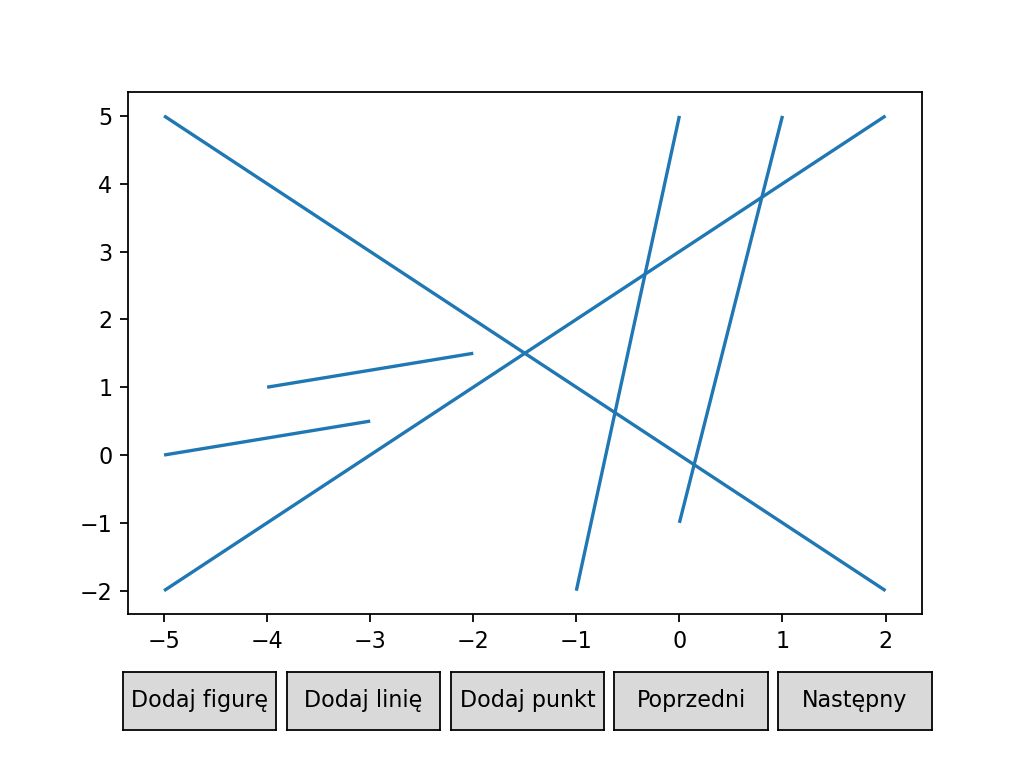

In [31]:
%matplotlib notebook

lines_set_1 = [
    ((-5,-2),(2,5)),
    ((-5,5),(2,-2)),
    ((-5,0),(-3,0.5)),
    ((-4,1),(-2,1.5)),
    ((-1,-2),(0,5)),
    ((0,-1),(1,5))
]

plot = Plot([Scene(lines=[LinesCollection(lines_set_1)])])
plot.draw()

# Zbiór testowy nr 2

<IPython.core.display.Javascript object>


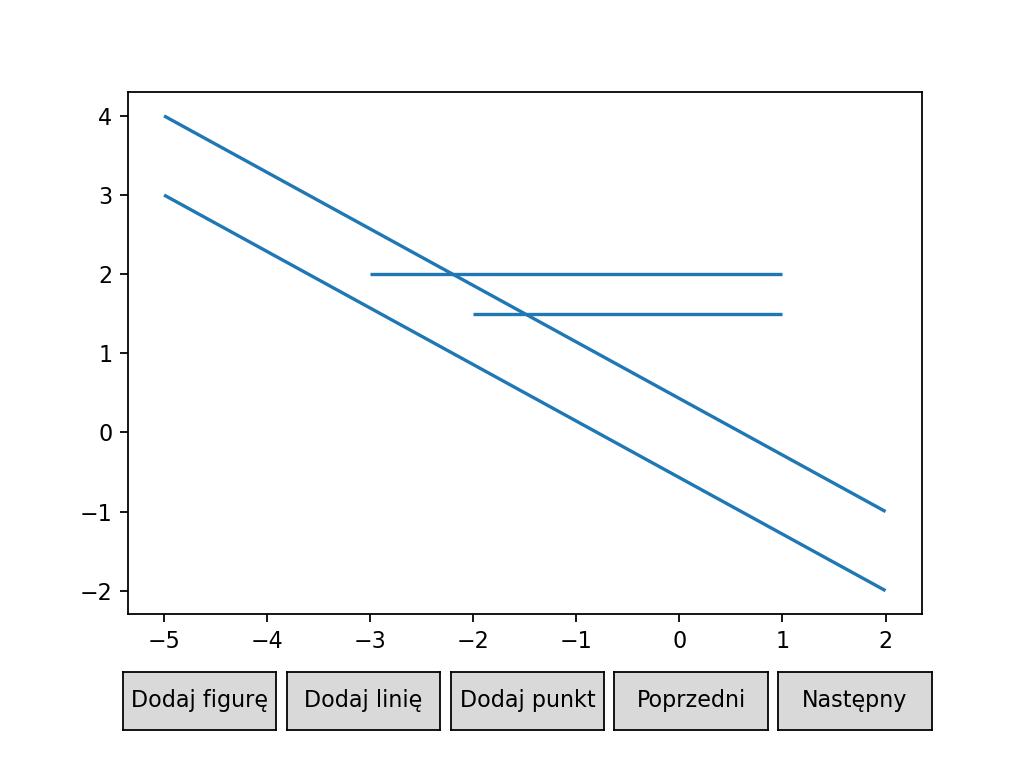

In [32]:
%matplotlib notebook

lines_set_2 = [
    ((-5,3),(2,-2)),
    ((-5,4),(2,-1)),
    ((-3,2),(1,2)),
    ((-2,1.5),(1,1.5))
]

plot = Plot([Scene(lines=[LinesCollection(lines_set_2)])])
plot.draw()

### Zamiatanie 1 - zbiór losowych linii

<IPython.core.display.Javascript object>


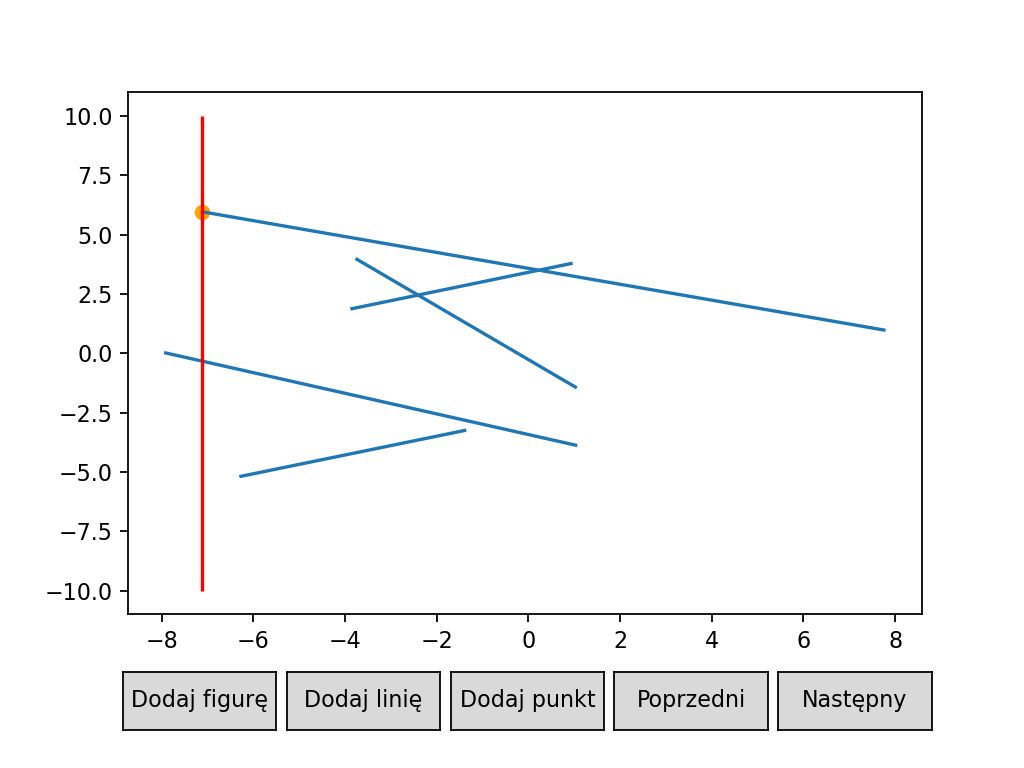

In [34]:
n = 5
left_lower_corner = (-10,-10)
right_upper_corner = (10,10)

random_lines = generate_random_lines(n, left_lower_corner, right_upper_corner)
broom_1_r = Broom_1(random_lines, left_lower_corner, right_upper_corner)
broom_1_r.sweep()

plot = Plot(broom_1_r.scenes)
plot.draw()

### Zamiatanie 2 - zbiór losowych linii

<IPython.core.display.Javascript object>


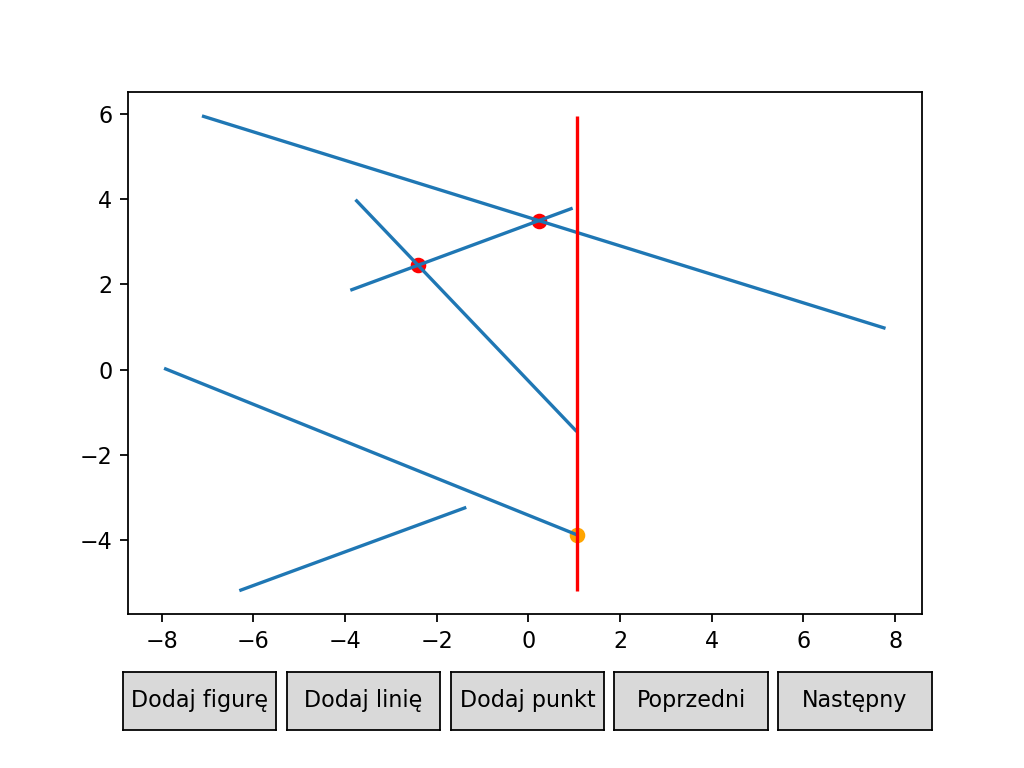

In [35]:
broom_2_r = Broom_2()
broom_2_r.sweep(convert_lines(random_lines.copy()))

plot = Plot(broom_2_r.scenes)
plot.draw()

### Zamiatanie 2 - zbiór testowy nr 1

Liczba przecięć: 5


<IPython.core.display.Javascript object>


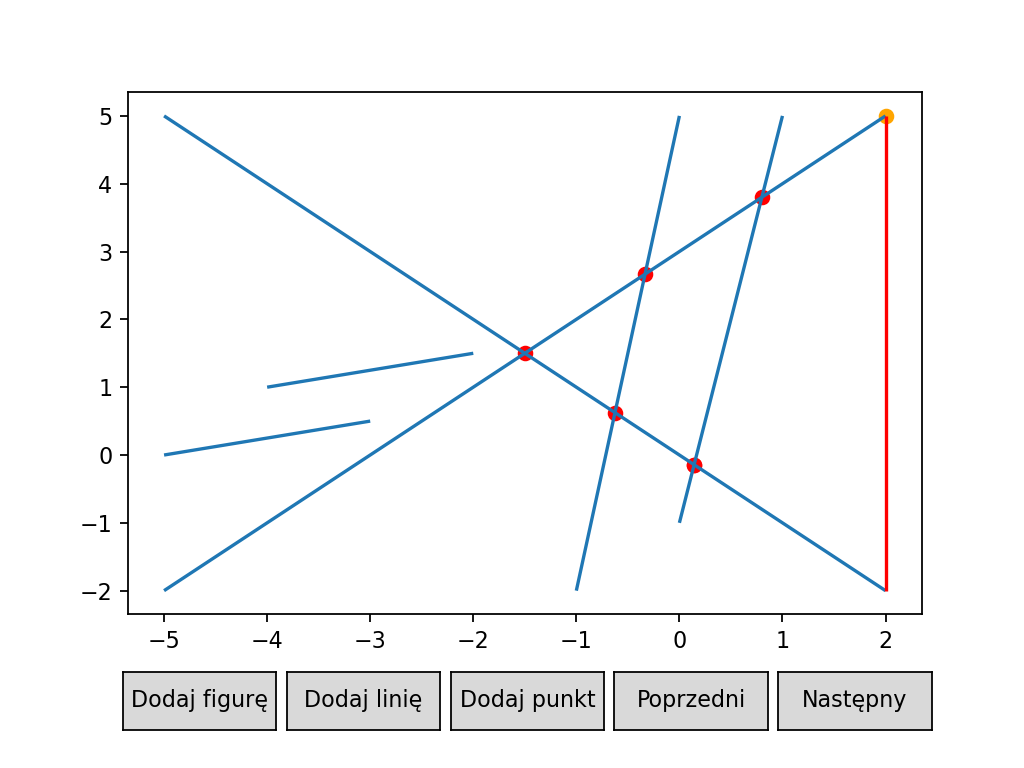

In [36]:
broom_2_1 = Broom_2()
broom_2_1.sweep(convert_lines(lines_set_1.copy()))

plot = Plot(broom_2_1.scenes)
print("Liczba przecięć:", len(broom_2_1.intersection)-1)
plot.draw()

### Zamiatanie 2 - zbiór testowy nr 2

Liczba przecięć: 2


<IPython.core.display.Javascript object>


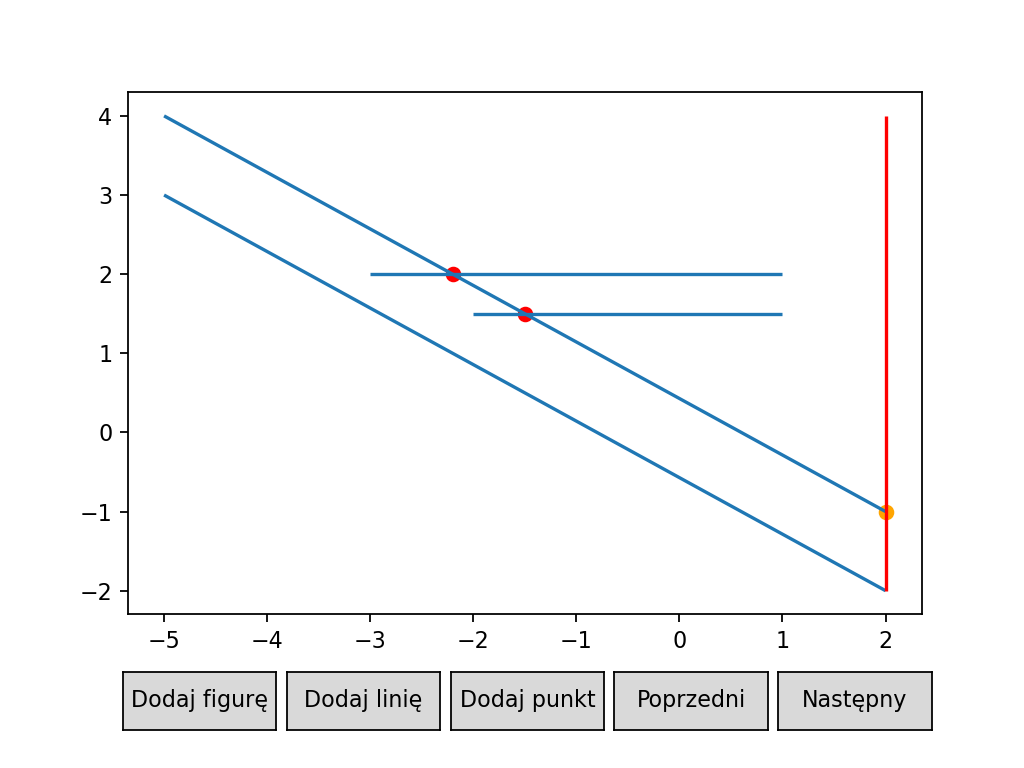

In [37]:
broom_2_2 = Broom_2()
broom_2_2.sweep(convert_lines(lines_set_2.copy()))

plot = Plot(broom_2_2.scenes)
print("Liczba przecięć:", len(broom_2_2.intersection))
plot.draw()